# Load dataset

In [1]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from mnist_rotate import MNISTRotate90
from torch.utils.data import DataLoader
import torchvision.transforms as T

transform = T.Compose([T.ToTensor()])
dataset = MNISTRotate90(size=28, transform=transform)
loader = DataLoader(dataset, batch_size=10000, shuffle=True)

imgs, digits, rot = next(iter(loader))  # imgs: (B,1,28,28)


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.29MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 303kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.70MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.38MB/s]


Subset shape: torch.Size([2078, 1, 28, 28])
Unique digits: [1, 3]
Rotation labels: [0, 1]


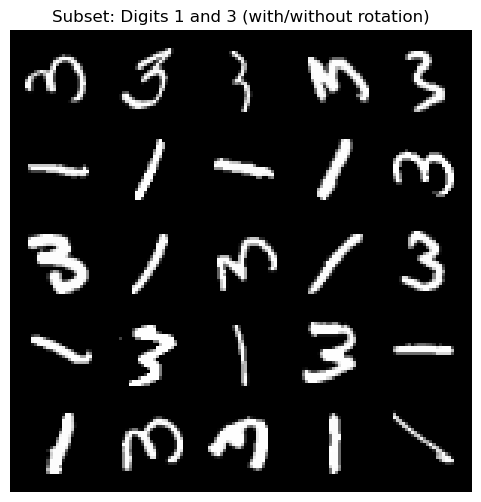

In [2]:
import torch

# Filter: keep only digits 1 and 3
mask = (digits == 1) | (digits == 3)

imgs = imgs[mask]
digits = digits[mask]
rot = rot[mask]

print("Subset shape:", imgs.shape)
print("Unique digits:", digits.unique().tolist())
print("Rotation labels:", rot.unique().tolist())

# Visualize first 25 samples
grid = make_grid(imgs[:25], nrow=5, padding=2, normalize=True)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1, 2, 0).numpy(), cmap="gray")
plt.axis("off")
plt.title("Subset: Digits 1 and 3 (with/without rotation)")
plt.show()


In [3]:

print("Batch shape:", imgs.shape)
print("Digits:", digits[:10].tolist())
print("Rot labels:", rot[:10].tolist())  # 0 = original, 1 = rotated


Batch shape: torch.Size([2078, 1, 28, 28])
Digits: [3, 3, 3, 3, 3, 1, 1, 1, 1, 3]
Rot labels: [1, 0, 0, 1, 0, 1, 0, 1, 0, 1]


In [4]:
import os
import matplotlib.pyplot as plt


os.makedirs("mnist_svgs_demo", exist_ok=True)


img1 = imgs[(digits == 1) & (rot == 0)][0]  
img3 = imgs[(digits == 3) & (rot == 0)][0]   

samples = [
    ("digit1_rot0", img1),
    ("digit1_rot90", torch.rot90(img1, 1, [1, 2])),
    ("digit3_rot0", img3),
    ("digit3_rot90", torch.rot90(img3, 1, [1, 2]))
]

# --- Save each as SVG ---
for name, img in samples:
    arr = img.squeeze().numpy()
    plt.figure(figsize=(1.5, 1.5))
    plt.imshow(arr, cmap="gray")
    plt.axis("off")
    plt.savefig(f"mnist_svgs_demo/{name}.svg", format="svg", bbox_inches="tight", pad_inches=0)
    plt.close()
    print("Saved:", f"mnist_svgs_demo/{name}.svg")


Saved: mnist_svgs_demo/digit1_rot0.svg
Saved: mnist_svgs_demo/digit1_rot90.svg
Saved: mnist_svgs_demo/digit3_rot0.svg
Saved: mnist_svgs_demo/digit3_rot90.svg


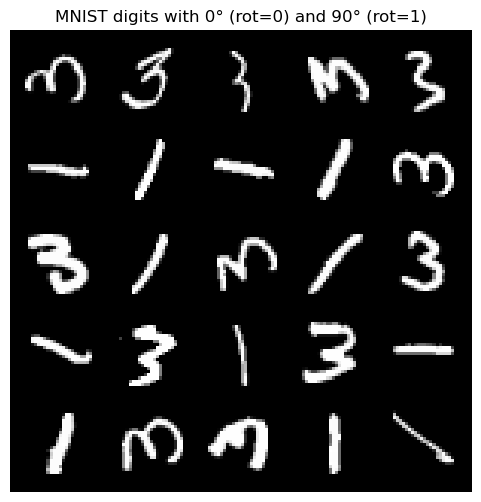

In [5]:


grid = make_grid(imgs[:25], nrow=5, padding=2, normalize=True)

plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1, 2, 0).numpy(), cmap="gray")
plt.axis("off")
plt.title("MNIST digits with 0° (rot=0) and 90° (rot=1)")
plt.show()


# Spectral

SpectralClustering (Gaussian affinity) accuracy: 0.982


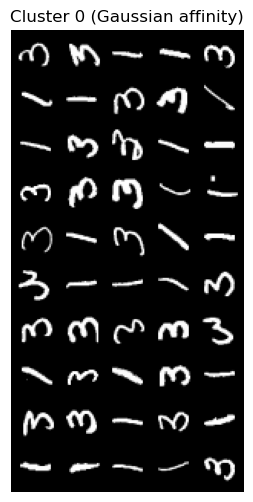

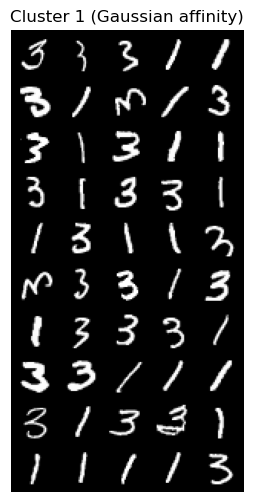

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.metrics import accuracy_score, pairwise_distances
from torchvision.utils import make_grid

X = imgs.view(imgs.size(0), -1).numpy()
D = pairwise_distances(X, metric="cosine")       # pairwise distances
sigma = np.median(D)                             # bandwidth
S = np.exp(-D**2 / (2 * sigma**2))               # Gaussian kernel

# --- 2. Spectral clustering ---
spec = SpectralClustering(n_clusters=2, affinity="precomputed", random_state=0)
clusters = spec.fit_predict(S)

# --- 3. Evaluate clustering ---
acc1 = accuracy_score(rot, clusters)
acc2 = accuracy_score(rot, 1 - clusters)  # account for label flip
acc = max(acc1, acc2)
print(f"SpectralClustering (Gaussian affinity) accuracy: {acc:.3f}")

# --- 4. Visualization helper ---
def plot_cluster(imgs, idx, title, n=50):
    n = min(n, len(idx))
    grid = make_grid(imgs[idx[:n]], nrow=5, padding=2, normalize=True)
    plt.figure(figsize=(6,6))
    plt.imshow(grid.permute(1, 2, 0).numpy(), cmap="gray")
    plt.axis("off")
    plt.title(title)
    plt.show()

cluster0_idx = np.where(clusters == 0)[0]
cluster1_idx = np.where(clusters == 1)[0]

plot_cluster(imgs, cluster0_idx, "Cluster 0 (Gaussian affinity)")
plot_cluster(imgs, cluster1_idx, "Cluster 1 (Gaussian affinity)")


## digit classes

In [7]:
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

from skimage.feature import hog

def rot90(img): return np.rot90(img)

X_imgs = imgs.squeeze().numpy()
features = []
for im in X_imgs:
    rots = [im, rot90(im), rot90(rot90(im)), rot90(rot90(rot90(im)))]
    hogs = [hog(r, pixels_per_cell=(4,4), cells_per_block=(1,1)) for r in rots]
    features.append(np.mean(hogs, axis=0))
X_feat = np.array(features)


D = pairwise_distances(X_feat, metric="euclidean")
sigma = np.median(D)
S = np.exp(-D**2 / (2 * sigma**2))

spec_digits = SpectralClustering(n_clusters=2, affinity="precomputed", random_state=0)
digit_clusters = spec_digits.fit_predict(S)


nmi = normalized_mutual_info_score(digits, digit_clusters)
ari = adjusted_rand_score(digits, digit_clusters)
print(f"Rotation-invariant Spectral (FFT magnitude, K=10) NMI={nmi:.3f}, ARI={ari:.3f}")


Rotation-invariant Spectral (FFT magnitude, K=10) NMI=0.863, ARI=0.917


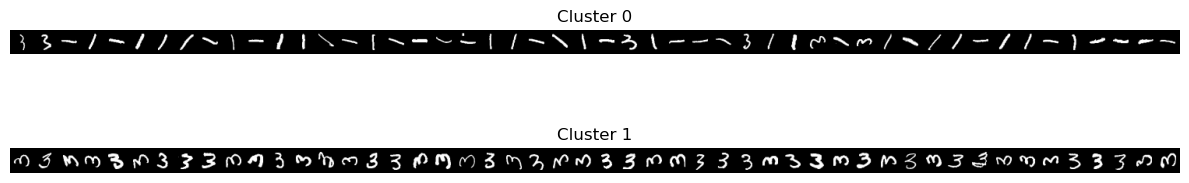

In [8]:

def plot_digits_by_cluster(imgs, clusters, n_clusters=10, n_per_cluster=10):
    plt.figure(figsize=(12, 12))
    for c in range(n_clusters):
        idx = np.where(clusters == c)[0][:n_per_cluster]
        if len(idx) == 0: continue
        grid = make_grid(imgs[idx], nrow=n_per_cluster, padding=2, normalize=True)
        plt.subplot(n_clusters, 1, c+1)
        plt.imshow(grid.permute(1,2,0).numpy(), cmap="gray")
        plt.axis("off")
        plt.title(f"Cluster {c}")
    plt.tight_layout()
    plt.show()

plot_digits_by_cluster(imgs, digit_clusters, n_clusters=10, n_per_cluster=50)


# VaDE: MFCVAE 

Use the file train_13.py in MFCVAE folder 

# SMT 

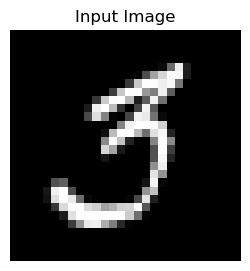

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import DictionaryLearning
from skimage.util import view_as_windows
import torch


img = img3[0]              
if torch.is_tensor(img):
    img = img.detach().cpu().numpy()

# Normalize between 0–1
img = img - img.min()
img = img / img.max()

plt.figure(figsize=(3,3))
plt.imshow(img, cmap='gray')
plt.title("Input Image")
plt.axis('off')
plt.show()


patch_size = 6
step = 3
patches = view_as_windows(img, (patch_size, patch_size), step=step)
patches = patches.reshape(-1, patch_size**2)
patches = patches - patches.mean(axis=1, keepdims=True)


In [10]:


n_atoms_lvl1 = 25
dl1 = DictionaryLearning(n_components=n_atoms_lvl1, alpha=1e-3, max_iter=500, random_state=0)
atoms_lvl1 = dl1.fit(patches).components_.reshape(n_atoms_lvl1, patch_size, patch_size)

corr = np.corrcoef(atoms_lvl1.reshape(n_atoms_lvl1, -1))
np.fill_diagonal(corr, 0)
pairs = np.unravel_index(np.argsort(-corr, axis=None), corr.shape)

n_atoms_lvl2 = 9
atoms_lvl2 = []
for i in range(n_atoms_lvl2):
    a, b = pairs[0][i], pairs[1][i]
    new_atom = (atoms_lvl1[a] + atoms_lvl1[b]) / 2
    atoms_lvl2.append(new_atom)
atoms_lvl2 = np.array(atoms_lvl2)


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.util import view_as_windows
import torch


img = img3[0]
if torch.is_tensor(img):
    img = img.detach().cpu().numpy()

# Normalize + binarize
img = (img - img.min()) / (img.max() - img.min())

patch_size_lvl1, step_lvl1 = 6, 3
patches_lvl1 = view_as_windows(img, (patch_size_lvl1, patch_size_lvl1), step=step_lvl1)
patches_lvl1 = patches_lvl1.reshape(-1, patch_size_lvl1, patch_size_lvl1)

patch_size_lvl2, step_lvl2 = 12, 6
patches_lvl2 = view_as_windows(img, (patch_size_lvl2, patch_size_lvl2), step=step_lvl2)
patches_lvl2 = patches_lvl2.reshape(-1, patch_size_lvl2, patch_size_lvl2)


def save_patches_svg(patches, filename, n_cols=10, max_patches=50):
    n_patches = min(len(patches), max_patches)
    print(n_patches)
    n_rows = int(np.ceil(n_patches / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, n_rows))
    axes = axes.ravel()
    for i in range(n_patches):
        axes[i].imshow(patches[i], cmap='gray', vmin=0, vmax=1)
        axes[i].axis('off')
    for ax in axes[n_patches:]:
        ax.axis('off')
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
    fig.patch.set_alpha(0.0)        # transparent background
    plt.savefig(filename, format='svg', transparent=True, bbox_inches='tight', pad_inches=0)
    plt.close(fig)


save_patches_svg(patches_lvl1, "atoms_level1.svg")
save_patches_svg(patches_lvl2, "atoms_level2.svg")



50
9


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.util import view_as_windows


selected_lvl2 = patches_lvl2[-2]   # or any index


patch_size_lvl1, step_lvl1 = 6, 3
subpatches_lvl1 = view_as_windows(selected_lvl2, (patch_size_lvl1, patch_size_lvl1), step=step_lvl1)
subpatches_lvl1 = subpatches_lvl1.reshape(-1, patch_size_lvl1, patch_size_lvl1)


def save_patches_svg(patches, filename, n_cols=6, pad=0.5, max_patches=None):
    if max_patches:
        patches = patches[:max_patches]
    n_patches = len(patches)
    n_rows = int(np.ceil(n_patches / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * pad, n_rows * pad))
    axes = axes.ravel()
    
    for i in range(n_patches):
        axes[i].imshow(patches[i], cmap='gray', vmin=0, vmax=1)
        axes[i].axis('off')
    for ax in axes[n_patches:]:
        ax.axis('off')

    plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=pad, hspace=pad)
    fig.patch.set_alpha(0.0)
    plt.savefig(filename, format='svg', transparent=True, bbox_inches='tight', pad_inches=0)
    plt.close(fig)


fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow(selected_lvl2, cmap='gray', vmin=0, vmax=1)
ax.axis('off')
fig.patch.set_alpha(0.0)
plt.savefig("atom_level2_patch.svg", format='svg', transparent=True, bbox_inches='tight', pad_inches=0)
plt.close(fig)


save_patches_svg(subpatches_lvl1, "atom_level2_decomposition.svg", n_cols=6, pad=0.5)

print("Saved: atom_level2_patch.svg and atom_level2_decomposition.svg")



Saved: atom_level2_patch.svg and atom_level2_decomposition.svg
